## Prepare data

### Only consider remove outliers

Read all the data. Apply simple outlier removal by validity range.

In [1]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


def remove_outliers(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
    df['voltage'] = df['voltage'].ffill()

    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].ffill()


base_dictionary = '../../robot_digital_twin/condition_monitoring_matlab_ros/matlab_application/collected_data/'
df_data = read_all_test_data_from_path(base_dictionary, remove_outliers, is_plot=False)

### Apply smoothing as a preprocessing

It can be seen that we have quite a lot of noise in the data, especitally on the voltage. Let's apply a sliding window smoothing to the remove the potential noise.

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt


# Function to design a Butterworth low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


# Function to apply the Butterworth low-pass filter
def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
    b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
    filtered_data = filtfilt(b, a, data)
    return filtered_data


# Set parameters for the low-pass filter
cutoff_frequency = .5  # Adjust as needed
sampling_frequency = 10  # Assuming your data is evenly spaced in time


def customized_outlier_removal(df: pd.DataFrame):
    ''' # Description
    Remove outliers from the dataframe based on defined valid ranges. 
    Define a valid range of temperature and voltage. 
    Use ffil function to replace the invalid measurement with the previous value.
    '''
    df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
    df['position'] = df['position'].where(df['position'] >= 0, np.nan)
    df['position'] = df['position'].ffill()
    df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
    # df['position'] = df['position'].rolling(window=10, min_periods=1).mean()
    df['position'] = df['position'].round()

    df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
    df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
    # df['temperature'] = df['temperature'].rolling(window=10, min_periods=1).mean()

    # Make sure that the difference between the current and previous temperature cannot be too large.
    # Define your threshold
    threshold = 10
    # Shift the 'temperature' column by one row to get the previous temperature
    prev_tmp = df['temperature'].shift(1)
    # Calculate the absolute difference between current and previous temperature
    temp_diff = np.abs(df['temperature'] - prev_tmp)
    # Set the temperature to NaN where the difference is larger than the threshold
    df.loc[temp_diff > threshold, 'temperature'] = np.nan
    df['temperature'] = df['temperature'].ffill()

    df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
    df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
    df['voltage'] = df['voltage'].ffill()
    # df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
    # df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()
    

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

base_dictionary = '../../robot_digital_twin/condition_monitoring_matlab_ros/matlab_application/collected_data/'
# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, customized_outlier_removal)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# # Visulize the data
# for selected_sequence_idx in path_list:
#     filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

#     print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
#         'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
#         'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
#     for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
#         'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
#         'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
#         ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
#         ax.set_ylabel(col)

#     plt.show()

## Define experiment supporting function

### Training the model for all motors, using all the features.

In the regression-based approach, we only need normal samples to learn the normal patterns.

In [3]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]


### We define a linear regression model.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


# Define the steps of the pipeline
steps = [
    ('standardizer', StandardScaler()),  # Step 1: StandardScaler
    ('regressor', LinearRegression())    # Step 2: Linear Regression
]

# Create the pipeline
mdl_linear_regreession = Pipeline(steps)

### Use `run_cv_one_motor` to run cross validation.

Like in the classification-based approach, we use `run_cv_one_motor` to run cross validation. The only difference is that we need to set `mdl_type = 'reg`. 

You can try to change the window_size as well.

You can set the parameter value `threshold` to control the threshold of residula error. If the absolute value of the residual error is larger than the threshold, the corresponding data point can be marked as failure. If you do not specify, `threshold` will take its default value of $3.$

If you set `single_run_result = False`, only the final results will be printed.

Below is a demo on motor 6:

Model for motor 6:

 New cv run:

Training performance, max error is: 8.626677004715916
Training performance, mean root square error is: 1.8314723398377528
Training performance, residual error > 3: 13.459058671824629%


Prediction performance, max error is: 14.20986436021256
Prediction performance, mean root square error is: 6.503248647233338
Prediction performance, percentage of residual error > 3：54.84660075425543%


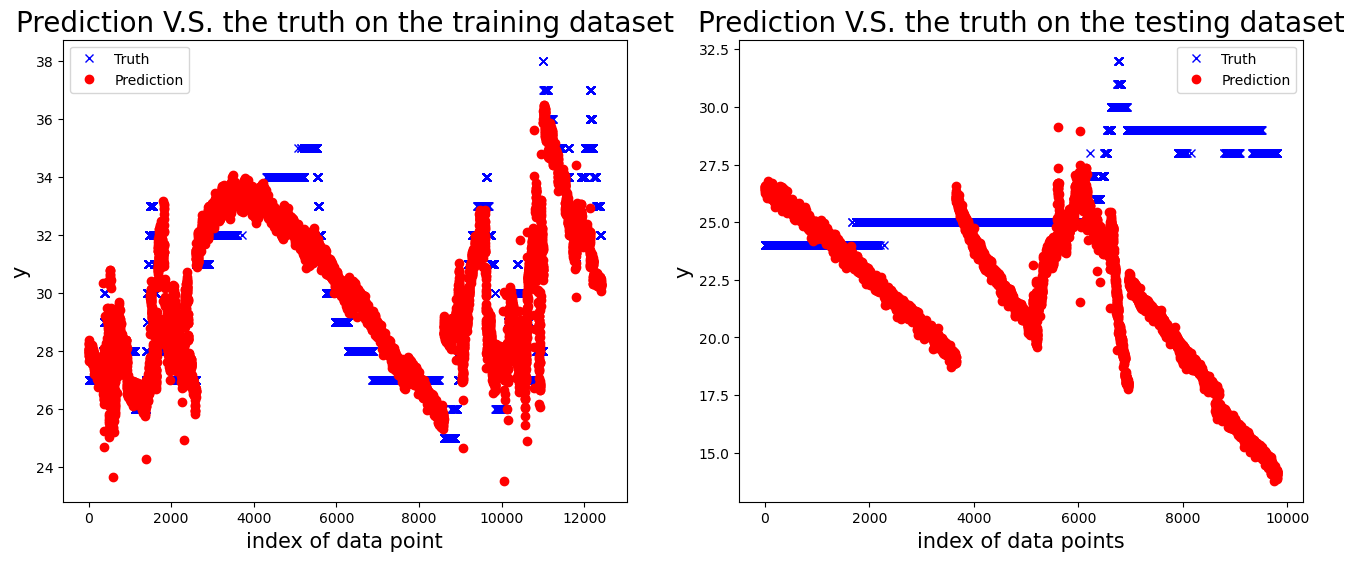

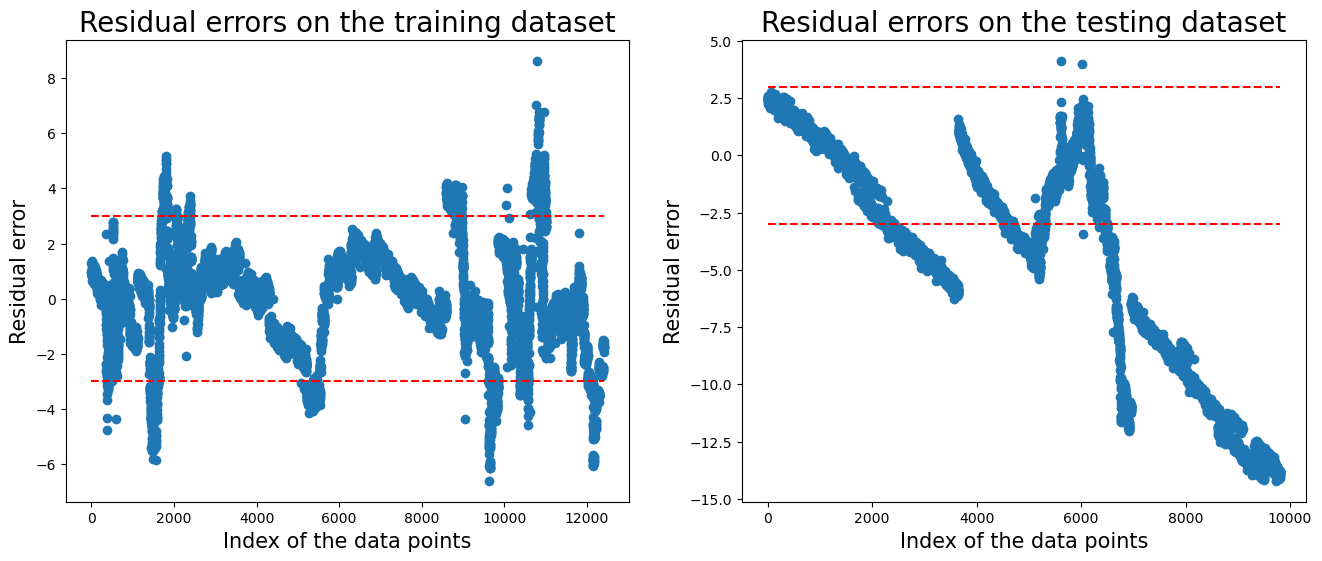

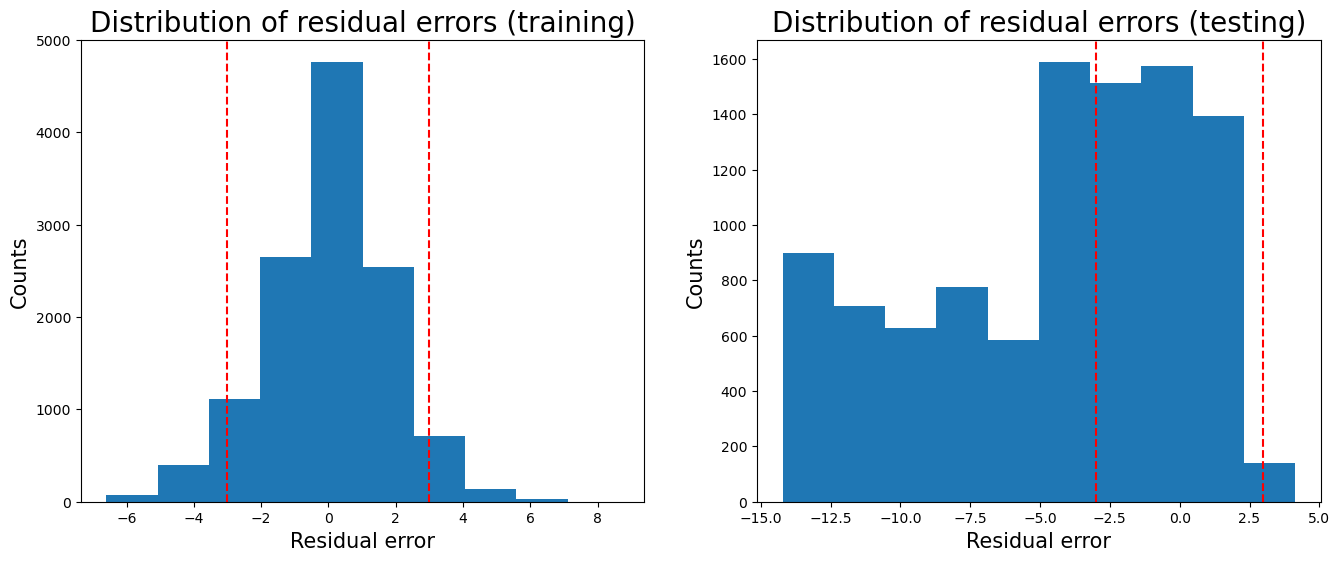


 New cv run:

Training performance, max error is: 9.458808087158623
Training performance, mean root square error is: 1.8481465739226082
Training performance, residual error > 3: 7.938012416473153%


Prediction performance, max error is: 14.916204534630086
Prediction performance, mean root square error is: 5.523604893885934
Prediction performance, percentage of residual error > 3：86.58318425760287%


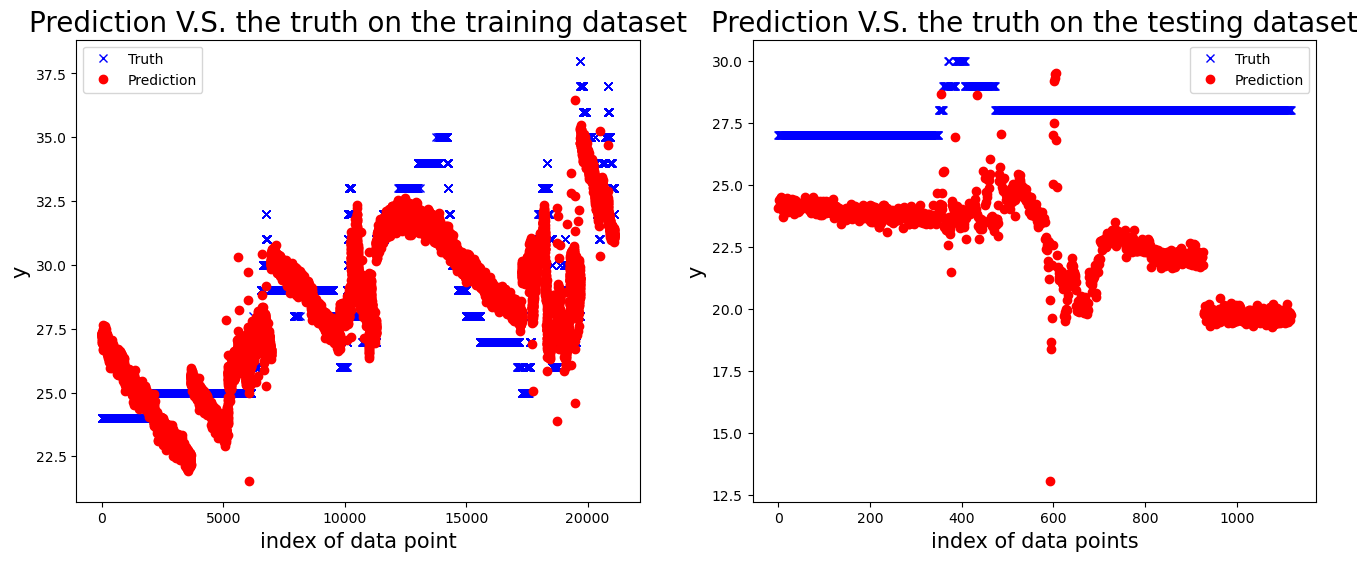

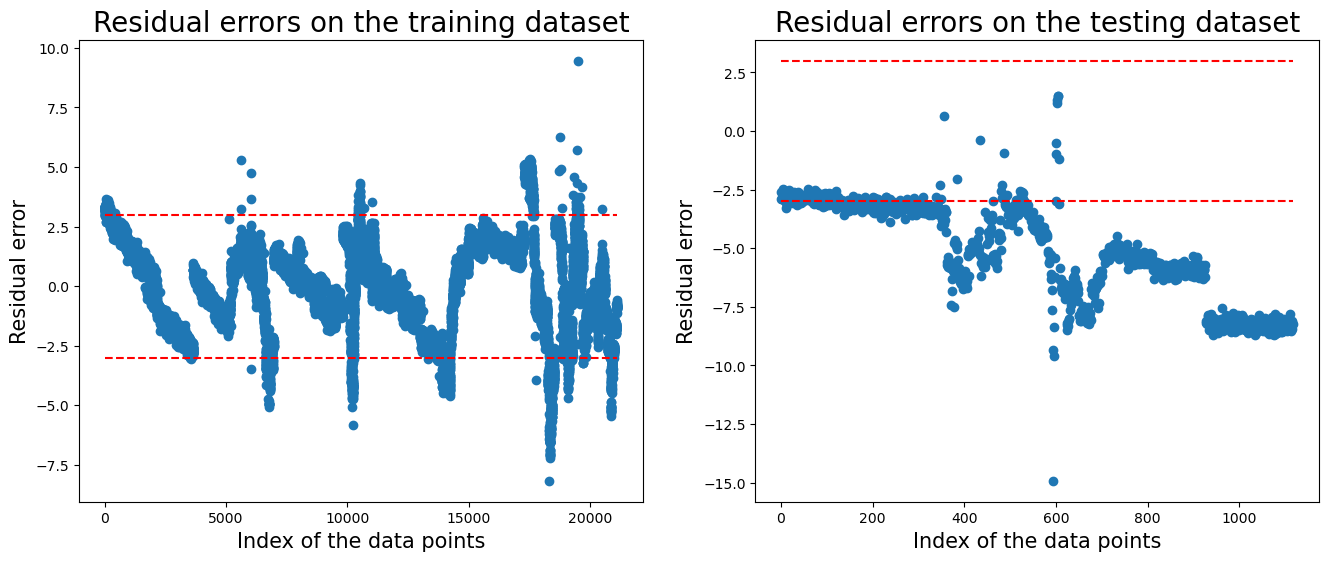

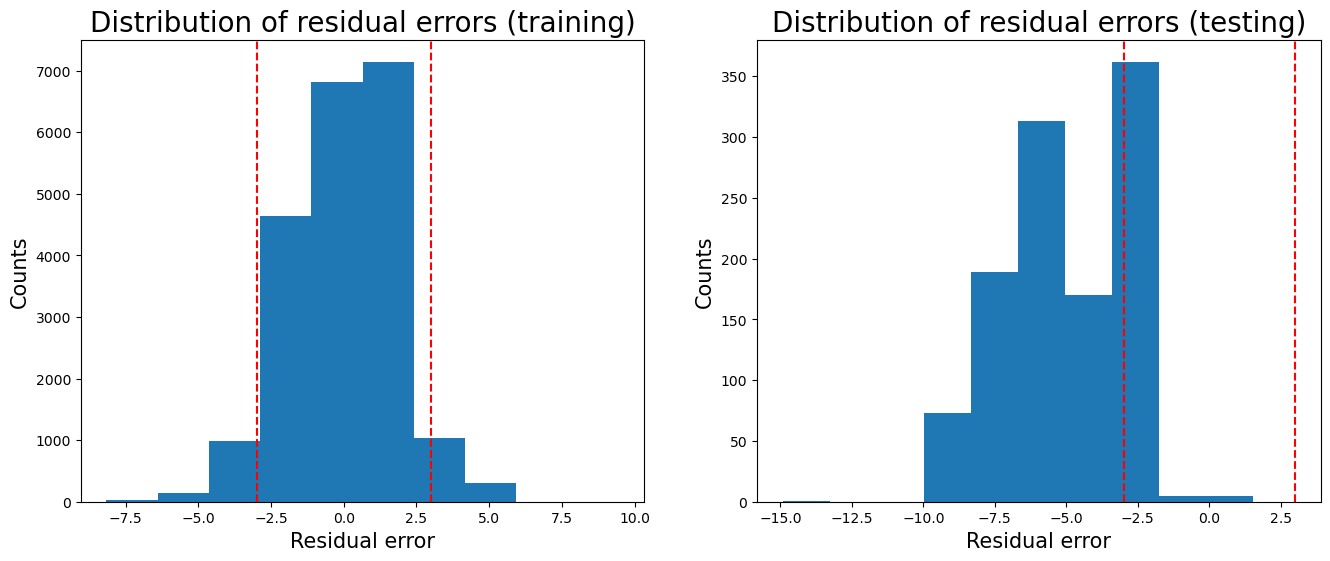


 New cv run:

Training performance, max error is: 7.179838125988937
Training performance, mean root square error is: 1.3962605079065813
Training performance, residual error > 3: 5.2053981907162985%


Prediction performance, max error is: 8.129535141505038
Prediction performance, mean root square error is: 4.227287775794867
Prediction performance, percentage of residual error > 3：46.307110958433526%


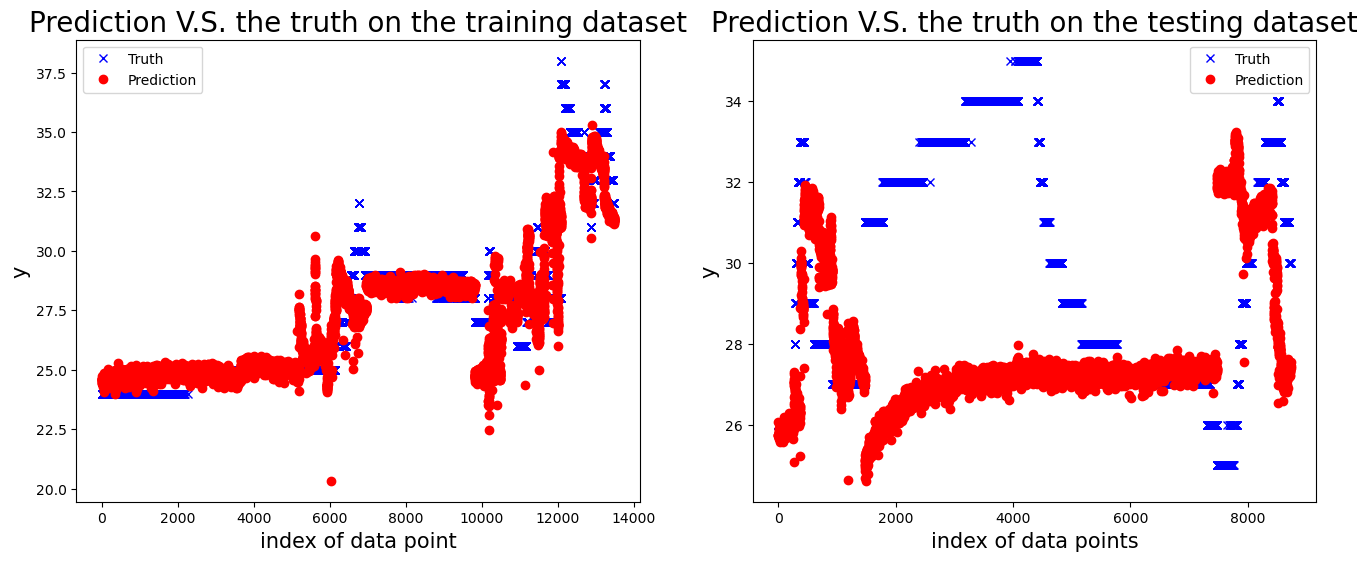

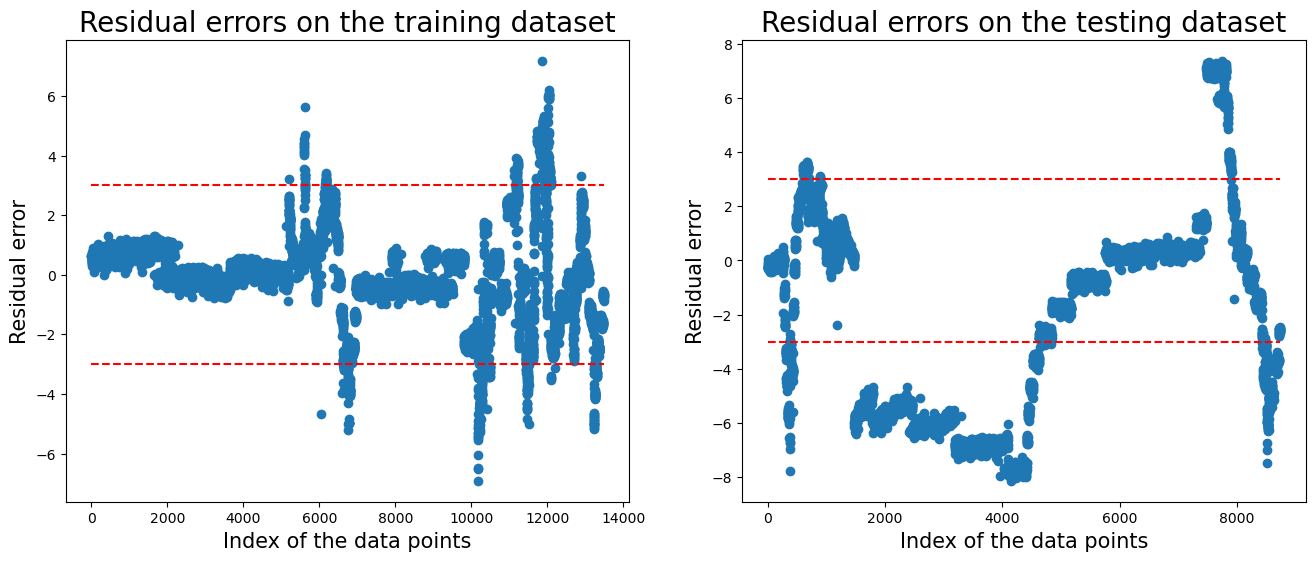

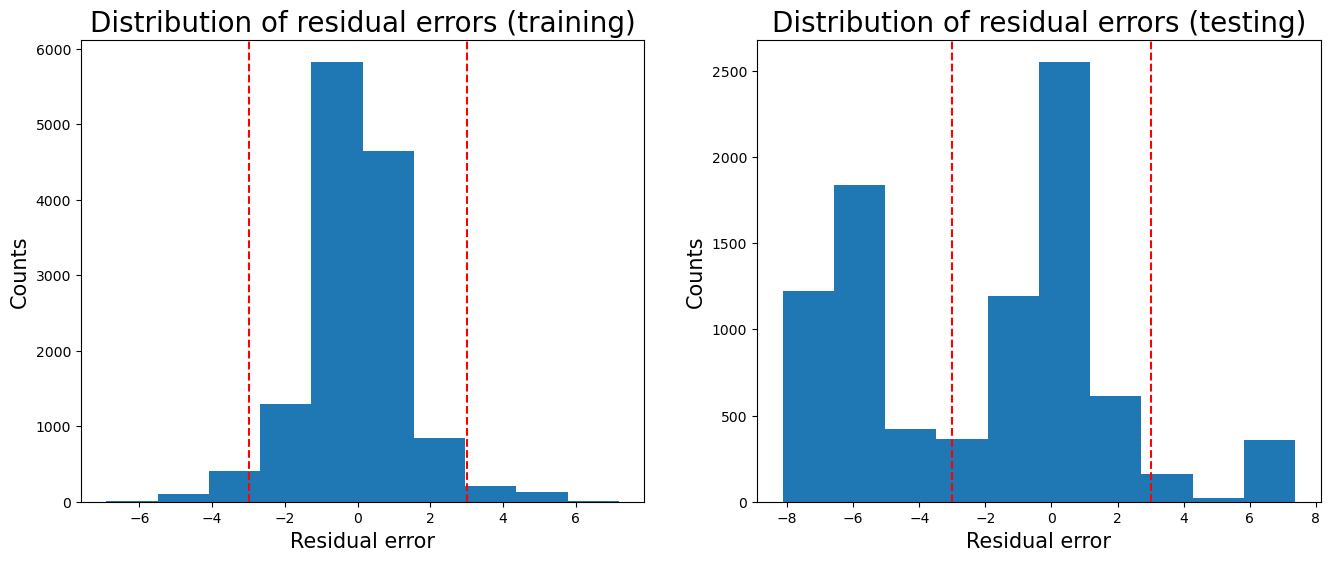


 New cv run:

Training performance, max error is: 10.231472761353075
Training performance, mean root square error is: 1.821861814828333
Training performance, residual error > 3: 7.849638104132617%


Prediction performance, max error is: 11.186460812677353
Prediction performance, mean root square error is: 5.16309754680308
Prediction performance, percentage of residual error > 3：49.62686567164179%


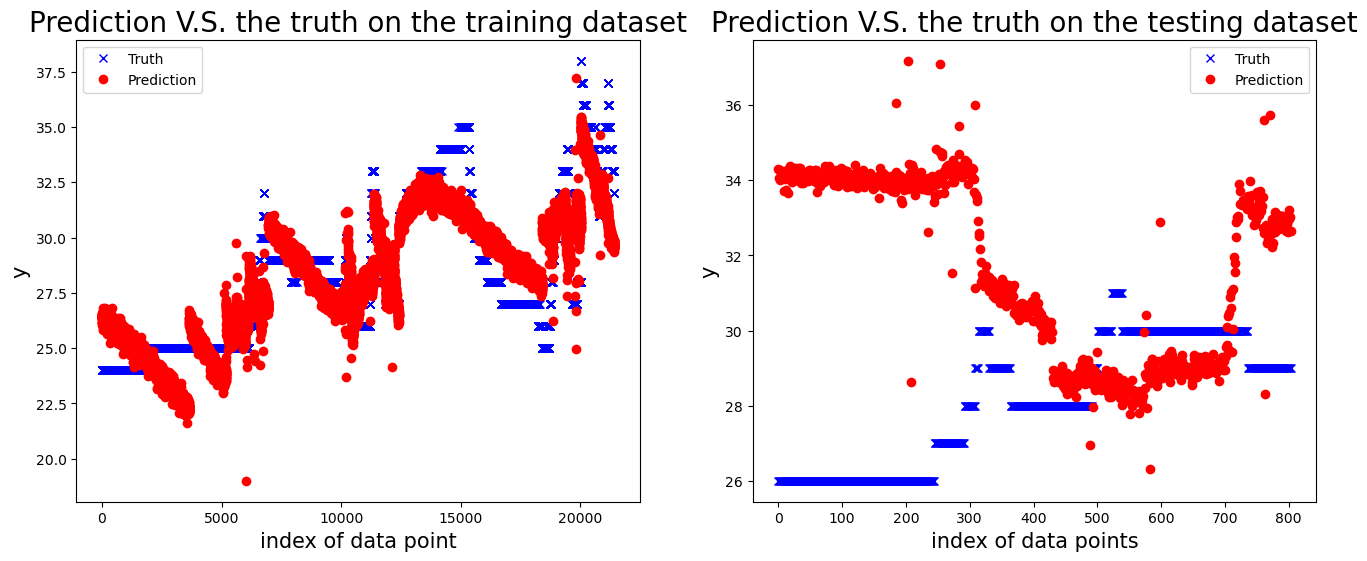

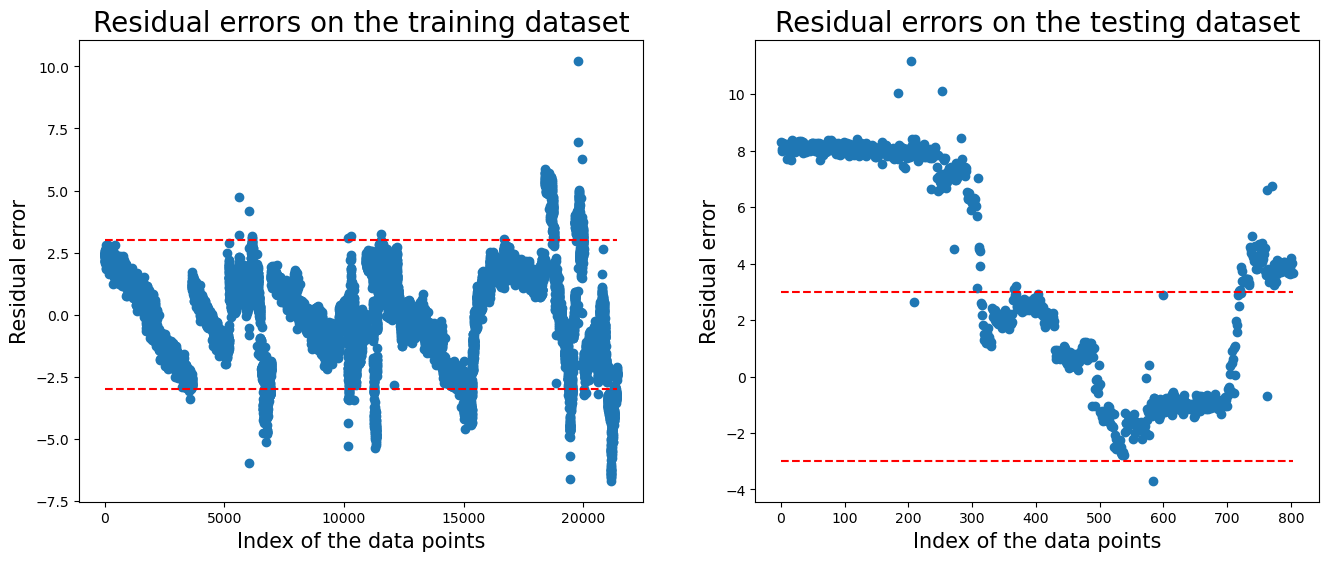

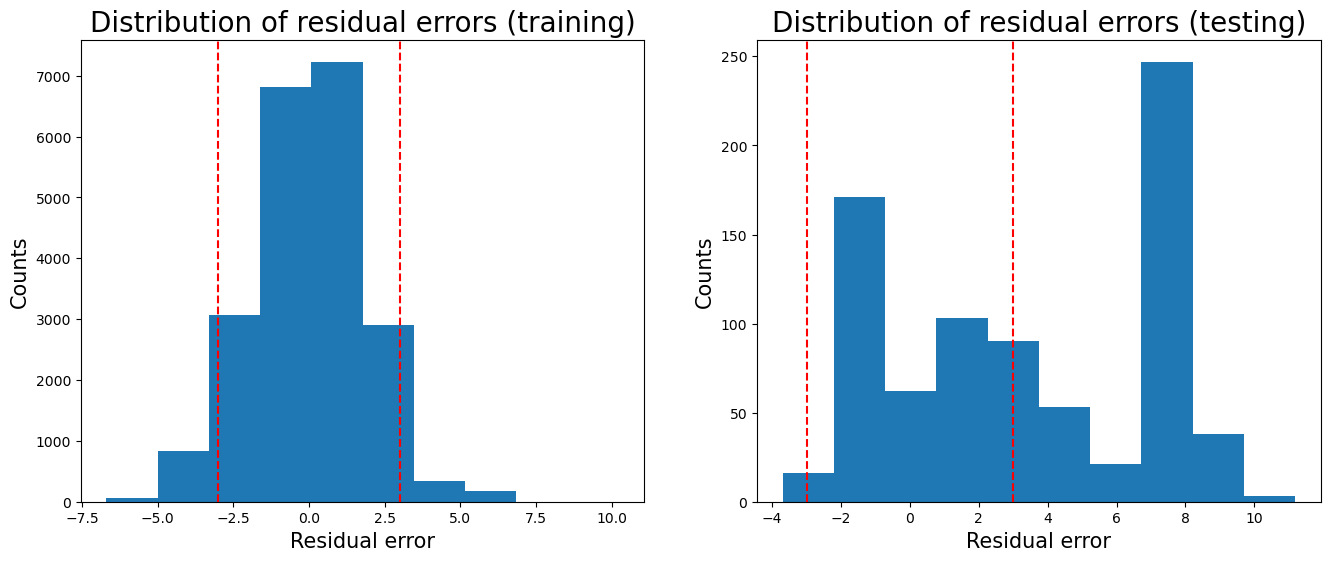


 New cv run:

Training performance, max error is: 8.434280587100577
Training performance, mean root square error is: 1.7891514892411866
Training performance, residual error > 3: 7.387862796833773%


Prediction performance, max error is: 9.631485791126966
Prediction performance, mean root square error is: 5.175136783894322
Prediction performance, percentage of residual error > 3：75.92698231602967%


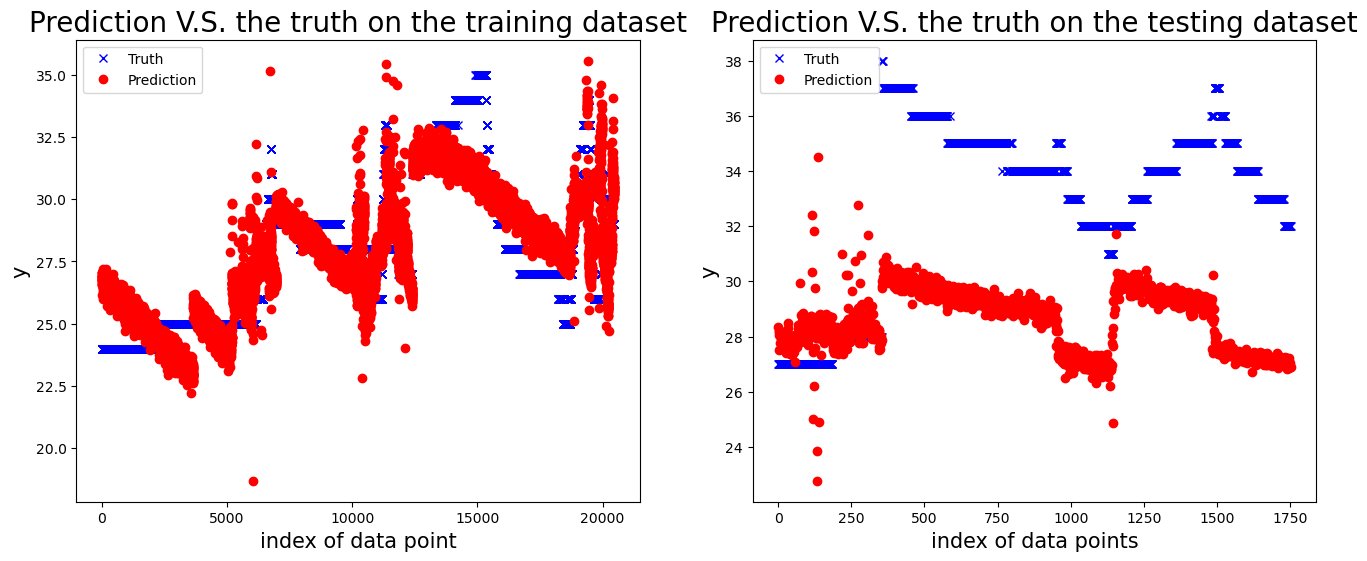

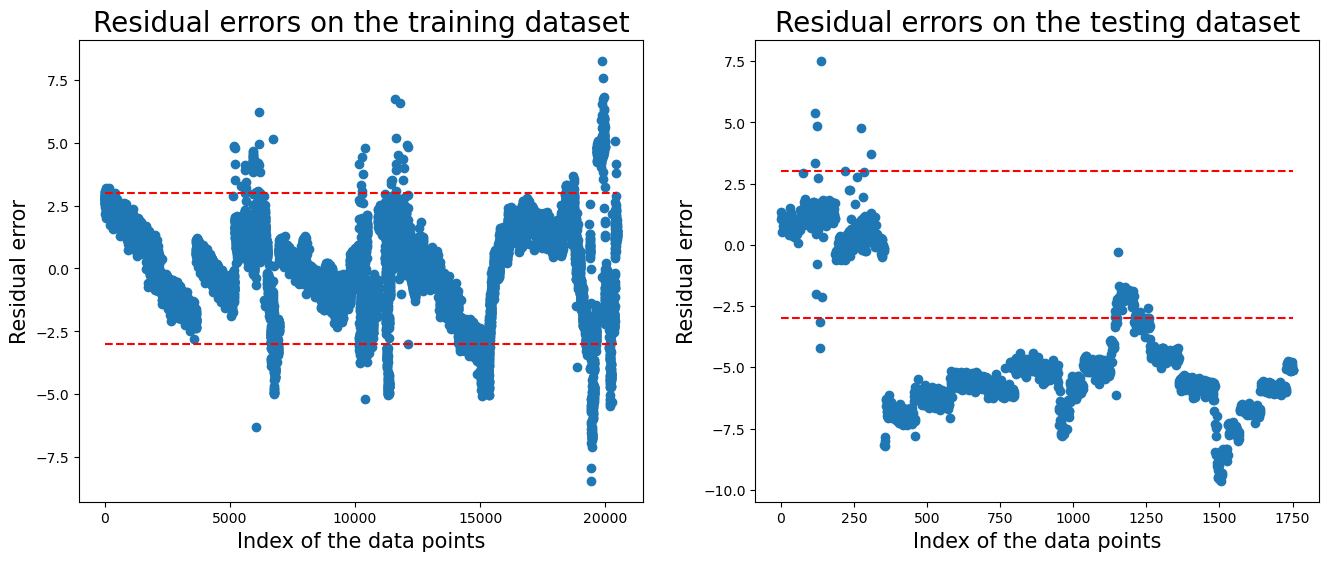

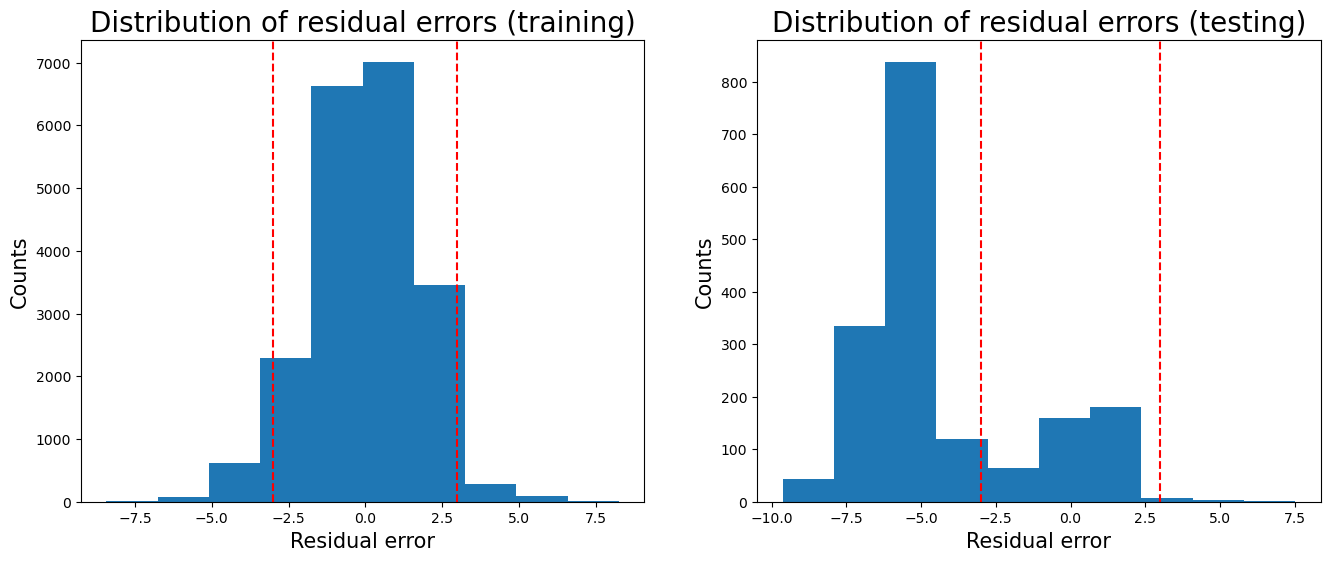

   Max error      RMSE  Exceed boundary rate
0  14.209864  6.503249              0.548466
1  14.916205  5.523605              0.865832
2   8.129535  4.227288              0.463071
3  11.186461  5.163098              0.496269
4   9.631486  5.175137              0.759270


Mean performance metric and standard error:
Max error: 11.6147 +- 2.9111
RMSE: 5.3185 +- 0.8187
Exceed boundary rate: 0.6266 +- 0.1765




In [5]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
df_perf = run_cv_one_motor(motor_idx=6, df_data=df_data, mdl=mdl_linear_regreession, 
            feature_list=feature_list_all, n_fold=5, mdl_type='reg')

### Define a function to run the cross validation for all the motors.

In [6]:
from utility import run_cv_one_motor


def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=0, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cv_one_motor(motor_idx=i, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, single_run_result=single_run_result, mdl_type=mdl_type)
        all_results.append(df_perf)

    return all_results

## Train a linear regression model using a 5-fold cross validation

Then, we run a 5 fold cross validation.

### Only removing outliers

In [7]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']
all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  30.582436  14.960041              0.726735
1  38.565166   9.026156              0.781753
2  26.012939  10.704650              0.966220
3  25.766062  12.597964              0.998756
4  20.807848   3.603193              0.436965


Mean performance metric and standard error:
Max error: 28.3469 +- 6.6775
RMSE: 10.1784 +- 4.2882
Exceed boundary rate: 0.7821 +- 0.2253


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0  10.044365  4.563991              0.434716
1  27.216599  9.148082              1.000000
2  14.459676  7.088114              0.827780
3   9.170366  5.026368              0.890547
4   7.932824  2.858879              0.277239


Mean performance metric and standard error:
Max error: 13.7648 +- 7.9120
RMSE: 5.7371 +- 2.4303
Exceed boundary rate: 0.6861 +- 0.3126


Model for predicting temperature of motor 3:
Mo

### Smoothing

In [9]:
all_results = run_all_motors(df_data=df_data_smoothing, mdl=mdl_linear_regreession, feature_list=feature_list_all, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  31.380439  14.964430              0.727449
1  38.439665   9.003718              0.783542
2  25.524253  10.746938              0.965190
3  26.223782  12.655432              1.000000
4  19.654987   3.646232              0.448945


Mean performance metric and standard error:
Max error: 28.2446 +- 7.0540
RMSE: 10.2034 +- 4.2840
Exceed boundary rate: 0.7850 +- 0.2208


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0  10.049706  4.546478              0.435226
1  15.191252  9.112354              1.000000
2  14.108338  7.232169              0.821024
3   9.233503  5.017266              0.889303
4   7.768752  2.861110              0.275528


Mean performance metric and standard error:
Max error: 11.2703 +- 3.2143
RMSE: 5.7539 +- 2.4410
Exceed boundary rate: 0.6842 +- 0.3121


Model for predicting temperature of motor 3:
Mo

## Use a sliding window to predict the next point

In this section, we show a demonstration of how to use a sliding window to predict the next point. We first define a window. Then, the previous points in the window will be used to predict the next point. When the window size shrink to 1, it is equial to the previous model.

### Only removing outliers

In [10]:
all_results = run_all_motors(df_data=df_data, mdl=mdl_linear_regreession, feature_list=feature_list_all, window_size=5, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.042538  0.132804                   0.0
1   1.176649  0.120449                   0.0
2   1.060378  0.164021                   0.0
3   1.059317  0.128469                   0.0
4   1.029478  0.179449                   0.0


Mean performance metric and standard error:
Max error: 1.0737 +- 0.0590
RMSE: 0.1450 +- 0.0254
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.112754  0.079704               0.00000
1  15.999680  0.561413               0.00272
2   1.186517  0.122341               0.00000
3   1.021455  0.100046               0.00000
4   1.017972  0.110739               0.00000


Mean performance metric and standard error:
Max error: 4.0677 +- 6.6706
RMSE: 0.1948 +- 0.2055
Exceed boundary rate: 0.0005 +- 0.0012


Model for predicting temperature of motor 3:
Model for m

### Smoothing

In [11]:
all_results = run_all_motors(df_data=df_data_smoothing, mdl=mdl_linear_regreession, feature_list=feature_list_all, window_size=5, single_run_result=False)

Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0   1.036330  0.132180                   0.0
1   1.171740  0.118949                   0.0
2   1.062172  0.163271                   0.0
3   1.059782  0.128539                   0.0
4   1.030790  0.179504                   0.0


Mean performance metric and standard error:
Max error: 1.0722 +- 0.0574
RMSE: 0.1445 +- 0.0257
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   1.017624  0.076546                   0.0
1   1.008461  0.094220                   0.0
2   1.018348  0.123435                   0.0
3   1.027719  0.092837                   0.0
4   1.012799  0.100413                   0.0


Mean performance metric and standard error:
Max error: 1.0170 +- 0.0072
RMSE: 0.0975 +- 0.0170
Exceed boundary rate: 0.0000 +- 0.0000


Model for predicting temperature of motor 3:
Model for m